In [1]:
import cv2
import os
import shutil
import numpy as np
from tqdm import tqdm
import yaml

# Data conv to yolo annotation

In [2]:
from tqdm import tqdm
import os
import cv2
import numpy as np

# Paths to the dataset directories
gt_fine_dir = "/kaggle/input/cityscapes/Cityspaces/gtFine"
output_dir = "/kaggle/working/data"

# Class mappings
native_ids = {
    'road': 7, 'sidewalk': 8, 'building': 11, 'wall': 12, 'fence': 13, 'pole': 17,
    'traffic light': 19, 'traffic sign': 20, 'vegetation': 21, 'terrain': 22, 'sky': 23,
    'person': 4, 'rider': 25, 'car': 26, 'truck': 27, 'bus': 28, 'train': 31,
    'motorcycle': 32, 'bicycle': 33,
}

yolo_train_ids = {
    'road': 0, 'sidewalk': 1, 'building': 2, 'wall': 3, 'fence': 4, 'pole': 5,
    'traffic light': 6, 'traffic sign': 7, 'vegetation': 8, 'terrain': 9, 'sky': 10,
    'person': 11, 'rider': 12, 'car': 13, 'truck': 14, 'bus': 15, 'train': 16,
    'motorcycle': 17, 'bicycle': 18,
}

# Reverse mapping for easy lookup
native_to_yolo = {v: yolo_train_ids[k] for k, v in native_ids.items()}

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "val", "labels"), exist_ok=True)

# Loop through train, val, and test splits
splits = ['train', 'val']
for split in splits:
    split_dir = os.path.join(gt_fine_dir, split)
    print(f"Processing {split} split...")

    # Count the total number of files for the progress bar
    total_files = sum(
        1 for city in os.listdir(split_dir) 
        for file in os.listdir(os.path.join(split_dir, city)) 
        if file.endswith('_gtFine_labelIds.png')
    )
    
    with tqdm(total=total_files, desc=f"{split} split") as pbar:
        for city in os.listdir(split_dir):
            city_dir = os.path.join(split_dir, city)
            for file in os.listdir(city_dir):
                if file.endswith('_gtFine_labelIds.png'):

                    # Input mask path
                    mask_path = os.path.join(city_dir, file)

                    # Read the label mask
                    label_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                    # Get unique class IDs present in the image
                    unique_classes = np.unique(label_mask)

                    # Process polygons for valid classes
                    H, W = label_mask.shape
                    yolo_annotations = []

                    for class_id in unique_classes:
                        if class_id in native_to_yolo:
                            yolo_class_id = native_to_yolo[class_id]

                            # Extract binary mask for the current class
                            binary_mask = (label_mask == class_id).astype(np.uint8) * 255

                            # Find contours for the current class
                            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                            for cnt in contours:
                                if cv2.contourArea(cnt) > 200:  # Filter small areas
                                    polygon = []
                                    for point in cnt:
                                        x, y = point[0]
                                        polygon.append(x / W)
                                        polygon.append(y / H)
                                    yolo_annotations.append((yolo_class_id, polygon))

                    # Save YOLO annotation file
                    if yolo_annotations:
                        yolo_file = file.replace('_gtFine_labelIds.png', '.txt')
                        yolo_path = os.path.join(output_dir, split, "labels")
                        os.makedirs(yolo_path, exist_ok=True)

                        with open(os.path.join(yolo_path, yolo_file), 'w') as f:
                            for yolo_class_id, polygon in yolo_annotations:
                                f.write(f"{yolo_class_id} ")
                                f.write(" ".join(map(str, polygon)))
                                f.write("\n")
                    pbar.update(1)


Processing train split...


train split: 100%|██████████| 2975/2975 [06:31<00:00,  7.61it/s]


Processing val split...


val split: 100%|██████████| 500/500 [01:07<00:00,  7.41it/s]


# Move files to working directory

In [3]:
import os
import shutil
from tqdm import tqdm

# Source and destination directories
source_dir = "/kaggle/input/cityscapes/Cityspaces/images"
destination_dir = "/kaggle/working/data"

# Ensure destination directories exist
os.makedirs(os.path.join(destination_dir, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(destination_dir, "val", "images"), exist_ok=True)

# Loop through train and val splits
splits = ['train', 'val']
for split in splits:
    source_split_dir = os.path.join(source_dir, split)
    destination_split_dir = os.path.join(destination_dir, split, "images")

    # Collect all image paths for progress tracking
    all_images = [
        os.path.join(source_split_dir, city, file)
        for city in os.listdir(source_split_dir)
        if os.path.isdir(os.path.join(source_split_dir, city))  # Ensure it's a city folder
        for file in os.listdir(os.path.join(source_split_dir, city))
        if file.endswith('.png') or file.endswith('.jpg')
    ]

    # Copy images directly to the destination
    with tqdm(total=len(all_images), desc=f"Copying {split} images") as pbar:
        for image_path in all_images:
            file_name = os.path.basename(image_path)
            # Replace '_leftImg8bit.png' with '.png'
            new_file_name = file_name.replace('_leftImg8bit.png', '.png')
            destination_path = os.path.join(destination_split_dir, new_file_name)

            shutil.copy(image_path, destination_path)
            pbar.update(1)

print("Images copied successfully.")


Copying val images: 100%|██████████| 500/500 [00:14<00:00, 34.10it/s]

Images copied successfully.


In [4]:
# Create the dataset YAML file
yaml_content = f"""train: /kaggle/working/data/train
val: /kaggle/working/data/val

nc: {len(yolo_train_ids)}
names: {list(yolo_train_ids.keys())}
"""

yaml_path = '/kaggle/working/dataset.yaml'
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

print(f"Dataset conversion completed. YAML file saved to {yaml_path}")

Dataset conversion completed. YAML file saved to /kaggle/working/dataset.yaml


# data viz

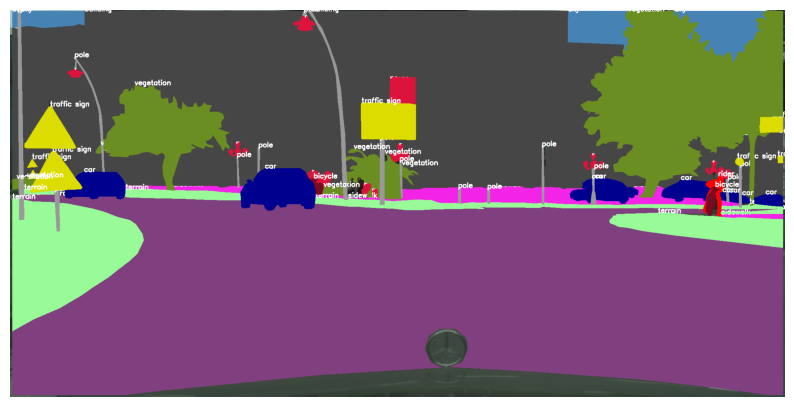

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the colors for each class
COLORS = {
    0: (128, 64, 128),  # road
    1: (244, 35, 232),  # sidewalk
    2: (70, 70, 70),    # building
    3: (102, 102, 156), # wall
    4: (190, 153, 153), # fence
    5: (153, 153, 153), # pole
    6: (250, 170, 30),  # traffic light
    7: (220, 220, 0),   # traffic sign
    8: (107, 142, 35),  # vegetation
    9: (152, 251, 152), # terrain
    10: (70, 130, 180), # sky
    11: (220, 20, 60),  # person
    12: (255, 0, 0),    # rider
    13: (0, 0, 142),    # car
    14: (0, 0, 70),     # truck
    15: (0, 60, 100),   # bus
    16: (0, 80, 100),   # train
    17: (0, 0, 230),    # motorcycle
    18: (119, 11, 32)   # bicycle
}

def draw_colored_polygons(image_path, label_path, output_path=None):
    """
    Draws the polygons described in the YOLO-style label file on the image with specified colors.

    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the YOLO-style label file.
        output_path (str, optional): Path to save the output image with drawn polygons.
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the label file
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        points = list(map(float, parts[1:]))
        polygon = [(int(points[i] * image.shape[1]), int(points[i + 1] * image.shape[0])) for i in range(0, len(points), 2)]

        # Get the color for the current class ID
        color = COLORS.get(class_id, (0, 255, 0))  # Default to green if not found

        # Draw the filled polygon
        if len(polygon) > 2:
            cv2.fillPoly(image, [np.array(polygon, np.int32)], color=color)

        # Add class name as text
        class_name = [key for key, value in yolo_train_ids.items() if value == class_id]
        class_name = class_name[0] if class_name else f"Unknown({class_id})"
        if polygon:
            cv2.putText(image, class_name, polygon[0], cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    # Show the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Save the image with polygons
    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Example Usage
image_path = r"/kaggle/working/data/train/images/aachen_000000_000019.png"
label_path = r"/kaggle/working/data/train/labels/aachen_000000_000019.txt"
draw_colored_polygons(image_path=image_path, label_path=label_path, output_path=None)

In [6]:
!pip install ultralytics
!pip install wandb --upgrade
import wandb
wandb.login(key='59f43b1aad54e12d1b7b5daaf2157c74904c5acd')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 85.9 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.19.1
    Uninstalling wandb-0.19.1:
      Successfully uninstalled wandb-0.19.1


wandb: Currently logged in as: elkholtihm4 (elkholtihm4-uae). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")
model.train(data="/kaggle/working/dataset.yaml", epochs=100, imgsz=640, device=0, project=None)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.74M/6.74M [00:00<00:00, 143MB/s]


Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/kaggle/working/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 23.8MB/s]


Overriding model.yaml nc=80 with nc=19

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 101MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data/train/labels... 2975 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2975/2975 [00:27<00:00, 109.88it/s]


train: New cache created: /kaggle/working/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data/val/labels... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:15<00:00, 32.63it/s]


val: New cache created: /kaggle/working/data/val/labels.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000435, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.76G      1.881       3.69      3.374       1.39       1929        640: 100%|██████████| 186/186 [06:48<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.35s/it]


                   all        500      35410      0.703      0.123       0.14     0.0914      0.704       0.12      0.137     0.0817

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.94G      1.711      3.192      1.924      1.301       1950        640: 100%|██████████| 186/186 [06:40<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.44s/it]


                   all        500      35410      0.534      0.177      0.189      0.115      0.522      0.168      0.177      0.096

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.49G      1.587      3.089      1.574      1.257       1299        640: 100%|██████████| 186/186 [06:48<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]


                   all        500      35410      0.452      0.205      0.215      0.131      0.448      0.191        0.2      0.112

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      8.06G      1.538      3.021      1.461      1.233       1614        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


                   all        500      35410      0.427       0.23      0.238      0.146      0.418      0.214       0.22      0.124

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      9.28G      1.506      2.976        1.4      1.217       1453        640: 100%|██████████| 186/186 [06:45<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


                   all        500      35410      0.376      0.237       0.25      0.153      0.371      0.223      0.233      0.129

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      8.42G      1.483      2.947      1.362      1.208       1413        640: 100%|██████████| 186/186 [06:49<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


                   all        500      35410      0.377      0.248      0.248      0.152       0.37      0.233      0.232      0.129

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      8.11G       1.47      2.927      1.331      1.197       1739        640: 100%|██████████| 186/186 [06:49<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


                   all        500      35410      0.396      0.261      0.262       0.16      0.378      0.243      0.243      0.137

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      5.67G      1.461        2.9      1.313      1.194       1728        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.50s/it]


                   all        500      35410       0.41      0.265      0.266      0.162      0.394      0.244      0.245      0.135

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.02G      1.439       2.87      1.282      1.183       1322        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


                   all        500      35410      0.403      0.274      0.274      0.167      0.383      0.248      0.251       0.14

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.35G      1.433      2.865      1.267      1.177       1378        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


                   all        500      35410       0.43      0.268      0.275      0.167      0.412      0.249      0.253       0.14

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.99G      1.423      2.853      1.253      1.174       1412        640: 100%|██████████| 186/186 [06:54<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.12s/it]


                   all        500      35410      0.413      0.275      0.276      0.169      0.393      0.252      0.253      0.142

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.48G      1.417      2.836      1.234      1.166       1690        640: 100%|██████████| 186/186 [06:45<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


                   all        500      35410      0.426      0.277      0.287      0.175      0.414      0.254      0.264      0.147

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      9.18G      1.406      2.816      1.223      1.165       1848        640: 100%|██████████| 186/186 [06:40<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


                   all        500      35410      0.423      0.277      0.283      0.172      0.409       0.26       0.26      0.144

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.73G      1.409      2.824      1.215      1.162       1600        640: 100%|██████████| 186/186 [06:45<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


                   all        500      35410      0.425      0.278      0.285      0.176      0.403      0.259      0.263      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.46G      1.397      2.803      1.202      1.158       1668        640: 100%|██████████| 186/186 [06:45<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


                   all        500      35410       0.45      0.284      0.289      0.177      0.429      0.263      0.266      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      8.67G      1.397      2.797      1.197      1.158       1553        640: 100%|██████████| 186/186 [06:41<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]


                   all        500      35410      0.423      0.285      0.288      0.176      0.409      0.262      0.266      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      8.27G      1.393      2.792      1.191      1.156       1492        640: 100%|██████████| 186/186 [06:44<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.23s/it]


                   all        500      35410      0.457      0.284      0.292      0.179      0.445      0.266      0.271      0.151

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      7.57G       1.38      2.772      1.173      1.152       1783        640: 100%|██████████| 186/186 [06:39<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all        500      35410      0.439      0.286      0.296      0.181      0.421      0.262       0.27      0.152

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      8.82G      1.383      2.782       1.17       1.15       1982        640: 100%|██████████| 186/186 [06:39<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all        500      35410      0.446      0.294      0.299      0.181      0.418      0.273       0.27       0.15

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.79G      1.376      2.765      1.159      1.145       1807        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


                   all        500      35410      0.434      0.285      0.294      0.179      0.415      0.264       0.27      0.148

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.62G      1.366       2.75      1.156      1.145       1911        640: 100%|██████████| 186/186 [06:48<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


                   all        500      35410      0.454      0.286        0.3      0.185      0.439      0.266      0.276      0.154

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.74G      1.364      2.746      1.145      1.142       1929        640: 100%|██████████| 186/186 [06:38<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


                   all        500      35410       0.44      0.301      0.303      0.185      0.443      0.271      0.279      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.87G      1.368      2.755      1.144      1.141       1606        640: 100%|██████████| 186/186 [06:38<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.45s/it]


                   all        500      35410      0.467      0.293      0.307      0.188      0.447       0.27      0.282      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.22G      1.354      2.726       1.13      1.138       1779        640: 100%|██████████| 186/186 [06:33<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


                   all        500      35410      0.466      0.293      0.306      0.187      0.452      0.266      0.278      0.155

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.59G      1.355      2.727      1.126      1.136       1356        640: 100%|██████████| 186/186 [06:33<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


                   all        500      35410       0.46      0.292      0.307      0.188      0.439      0.275      0.284      0.158

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.64G      1.352      2.717      1.122      1.136       1545        640: 100%|██████████| 186/186 [06:34<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all        500      35410      0.456      0.301       0.31      0.188      0.446      0.271      0.281      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.59G       1.35       2.72      1.117      1.133       1367        640: 100%|██████████| 186/186 [06:38<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


                   all        500      35410      0.454      0.301      0.313      0.192      0.434      0.276      0.286      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.86G       1.35      2.718      1.115      1.135       1702        640: 100%|██████████| 186/186 [06:53<00:00,  2.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


                   all        500      35410      0.461      0.302      0.311       0.19      0.437      0.278      0.285      0.158

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      9.77G      1.346      2.715      1.105      1.131       1641        640: 100%|██████████| 186/186 [06:51<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


                   all        500      35410      0.465      0.298      0.313      0.191      0.453      0.276      0.288      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.24G      1.346      2.707      1.103      1.131       1920        640: 100%|██████████| 186/186 [06:48<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


                   all        500      35410      0.456      0.305      0.314      0.193      0.434      0.284       0.29      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      8.04G      1.341      2.708      1.101      1.132       1458        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.43s/it]


                   all        500      35410       0.47      0.299      0.315      0.192      0.444      0.276      0.287      0.159

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      9.62G      1.333      2.696      1.092      1.126       2045        640: 100%|██████████| 186/186 [06:46<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]


                   all        500      35410      0.454      0.307      0.313      0.194      0.421      0.291      0.291      0.162

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      9.23G      1.331      2.681      1.088      1.123       2045        640: 100%|██████████| 186/186 [06:49<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


                   all        500      35410      0.474      0.299      0.315      0.194      0.452      0.277       0.29      0.162

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.68G      1.336      2.697      1.088      1.127       1292        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


                   all        500      35410       0.46      0.298      0.314      0.193       0.44      0.276      0.289      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.55G      1.329      2.682      1.082      1.124       1553        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


                   all        500      35410      0.463      0.299      0.317      0.194       0.44      0.274       0.29      0.161

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.65G      1.325      2.684      1.078      1.121       1463        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


                   all        500      35410      0.464      0.307      0.319      0.197      0.448      0.281      0.292      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.81G      1.323      2.679      1.073      1.121       1664        640: 100%|██████████| 186/186 [06:49<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


                   all        500      35410      0.467      0.309      0.324      0.201      0.442      0.283      0.297      0.168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      9.14G      1.318       2.67      1.063      1.118       1650        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.25s/it]


                   all        500      35410      0.478      0.307       0.32      0.197      0.455      0.284      0.295      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100       8.8G       1.32      2.665      1.062      1.118       1659        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.48s/it]


                   all        500      35410      0.477      0.306      0.323      0.199      0.451       0.28      0.293      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.95G      1.318      2.667      1.064      1.117       1063        640: 100%|██████████| 186/186 [06:42<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all        500      35410      0.464      0.311      0.319      0.196       0.45      0.279      0.291      0.162

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100       8.4G      1.308      2.645      1.057      1.115       1865        640: 100%|██████████| 186/186 [06:49<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


                   all        500      35410      0.462      0.312      0.323      0.198      0.442      0.287      0.295      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.07G      1.306      2.653      1.055      1.113       1751        640: 100%|██████████| 186/186 [06:50<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all        500      35410      0.471      0.305      0.318      0.196      0.453       0.28       0.29      0.162

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      8.23G      1.315       2.66      1.053      1.113       1545        640: 100%|██████████| 186/186 [07:00<00:00,  2.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


                   all        500      35410      0.497      0.302       0.32      0.197      0.483      0.278      0.294      0.163

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100       7.5G      1.314      2.658      1.053      1.114       1848        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


                   all        500      35410      0.486       0.31      0.325        0.2       0.46      0.284      0.297      0.166

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      8.24G      1.306       2.65      1.045      1.111       2069        640: 100%|██████████| 186/186 [06:50<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


                   all        500      35410      0.482      0.303      0.326      0.202      0.468      0.283      0.299      0.167

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      8.68G      1.305      2.632      1.041       1.11       1970        640: 100%|██████████| 186/186 [06:48<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.56s/it]


                   all        500      35410      0.484      0.307      0.327      0.201      0.464      0.286      0.301      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      7.59G      1.299      2.642      1.036      1.107       1615        640: 100%|██████████| 186/186 [06:50<00:00,  2.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.31s/it]


                   all        500      35410      0.475      0.307      0.325      0.199      0.444      0.284      0.295      0.164

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      7.06G      1.306      2.646       1.04      1.108       1893        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.54s/it]


                   all        500      35410      0.472      0.314      0.327        0.2      0.445      0.289      0.298      0.165

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      8.36G      1.296       2.64      1.031      1.105       1792        640: 100%|██████████| 186/186 [06:40<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.55s/it]


                   all        500      35410      0.469      0.312      0.328      0.202      0.451      0.288      0.299      0.167

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100       7.8G      1.297      2.623      1.026      1.106       1258        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


                   all        500      35410      0.481       0.31      0.326      0.201      0.458      0.287      0.299      0.166

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      8.34G      1.291      2.626      1.028      1.103       1750        640: 100%|██████████| 186/186 [06:46<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


                   all        500      35410      0.477      0.308      0.322      0.199      0.448      0.284      0.297      0.165

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      9.27G      1.291       2.62      1.024      1.104       1560        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


                   all        500      35410      0.468      0.313      0.328      0.201      0.454      0.288      0.301      0.168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      7.74G      1.284      2.613      1.023      1.104       1579        640: 100%|██████████| 186/186 [06:40<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


                   all        500      35410      0.467       0.32      0.333      0.204      0.448      0.291      0.303      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      7.44G      1.289      2.613      1.017      1.102       1680        640: 100%|██████████| 186/186 [06:45<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


                   all        500      35410      0.483      0.311      0.329      0.203       0.46      0.289      0.304      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      8.06G      1.284       2.61      1.018      1.103       1692        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.44s/it]


                   all        500      35410      0.475      0.316      0.331      0.204      0.458      0.287      0.303      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      7.98G      1.284      2.608      1.014      1.102       1813        640: 100%|██████████| 186/186 [06:46<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


                   all        500      35410      0.484      0.308      0.331      0.203      0.461      0.287      0.303      0.168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.93G      1.288      2.602      1.014      1.102       2180        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.58s/it]


                   all        500      35410      0.478      0.314      0.334      0.206      0.468      0.289      0.308      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      8.73G      1.287      2.606       1.01      1.098       1570        640: 100%|██████████| 186/186 [06:42<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.33s/it]


                   all        500      35410      0.482      0.313      0.331      0.203      0.462      0.286      0.303      0.168

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.46G       1.28      2.603      1.004      1.098       1187        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


                   all        500      35410      0.484      0.311      0.328      0.202      0.472      0.282        0.3      0.166

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      8.03G      1.276      2.596      1.002      1.097       1792        640: 100%|██████████| 186/186 [06:49<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.36s/it]


                   all        500      35410      0.476       0.32      0.335      0.206      0.477      0.292      0.307       0.17

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.76G      1.271      2.587      0.994      1.094       1679        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


                   all        500      35410      0.493      0.314      0.335      0.207       0.47      0.291      0.308      0.171

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.09G      1.281      2.602      1.004      1.098       1601        640: 100%|██████████| 186/186 [06:44<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.28s/it]


                   all        500      35410      0.486      0.315      0.332      0.205      0.458      0.295      0.304      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100       7.3G      1.274       2.59     0.9977      1.097       1339        640: 100%|██████████| 186/186 [06:48<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]


                   all        500      35410      0.464      0.317      0.331      0.204      0.464      0.289      0.306       0.17

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      8.24G      1.279      2.606      0.998      1.095       1704        640: 100%|██████████| 186/186 [06:43<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all        500      35410      0.475       0.32      0.334      0.206      0.452      0.293      0.306       0.17

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.66G      1.268      2.581     0.9919      1.095       1648        640: 100%|██████████| 186/186 [06:49<00:00,  2.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


                   all        500      35410      0.483      0.321      0.334      0.206      0.453      0.298      0.308      0.171

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.49G      1.272      2.588     0.9919      1.093       1522        640: 100%|██████████| 186/186 [06:52<00:00,  2.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.16s/it]


                   all        500      35410      0.481      0.318      0.336      0.208      0.449      0.295      0.307      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      8.64G      1.269      2.582     0.9857      1.091       1413        640: 100%|██████████| 186/186 [06:47<00:00,  2.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


                   all        500      35410      0.498      0.315      0.337      0.208       0.48      0.289      0.307      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      9.11G      1.262      2.572     0.9842      1.089       1527        640: 100%|██████████| 186/186 [06:44<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


                   all        500      35410      0.482      0.319      0.337      0.208       0.46      0.294      0.309      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100       8.1G      1.264      2.575     0.9822      1.089       1520        640: 100%|██████████| 186/186 [06:45<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.38s/it]


                   all        500      35410      0.479      0.323      0.337      0.208      0.464      0.291      0.308      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      9.01G      1.261      2.567     0.9812      1.091       1978        640: 100%|██████████| 186/186 [06:33<00:00,  2.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.62s/it]


                   all        500      35410      0.492      0.316      0.335      0.207      0.487      0.285      0.307      0.171

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.76G      1.267      2.582     0.9814      1.089       2044        640: 100%|██████████| 186/186 [06:41<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.47s/it]


                   all        500      35410      0.482      0.321      0.337      0.208      0.466      0.293      0.309      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      8.62G      1.268      2.579     0.9838      1.091       2006        640: 100%|██████████| 186/186 [06:44<00:00,  2.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


                   all        500      35410      0.477      0.318      0.336      0.206       0.46      0.289      0.306      0.171

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.86G      1.262      2.564     0.9752      1.088       1592        640: 100%|██████████| 186/186 [06:36<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.50s/it]


                   all        500      35410      0.476      0.322      0.336      0.208      0.461       0.29      0.307      0.171

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.62G      1.256      2.563     0.9767      1.087       1706        640: 100%|██████████| 186/186 [06:39<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.40s/it]


                   all        500      35410      0.478      0.323      0.338      0.208       0.46      0.295       0.31      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.68G      1.254      2.557     0.9728      1.087       1309        640: 100%|██████████| 186/186 [06:38<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


                   all        500      35410      0.485      0.321      0.338      0.209      0.457      0.298       0.31      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.05G       1.26      2.569     0.9763      1.089       1623        640: 100%|██████████| 186/186 [06:40<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


                   all        500      35410       0.49      0.321      0.338      0.207      0.459      0.297      0.307      0.171

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.07G       1.25      2.545      0.967      1.084       1484        640: 100%|██████████| 186/186 [06:41<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.27s/it]


                   all        500      35410      0.483      0.324      0.339      0.209      0.464      0.297       0.31      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.45G       1.25      2.549     0.9676      1.085       1711        640: 100%|██████████| 186/186 [06:40<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


                   all        500      35410      0.496       0.32      0.339       0.21      0.476      0.292       0.31      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      9.01G      1.249      2.548     0.9645      1.082       1510        640: 100%|██████████| 186/186 [06:39<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.32s/it]


                   all        500      35410      0.489      0.321       0.34       0.21       0.47      0.292      0.313      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      9.67G      1.249      2.548     0.9576      1.081       1579        640: 100%|██████████| 186/186 [06:41<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


                   all        500      35410      0.489      0.324       0.34       0.21      0.458      0.301      0.314      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.18G      1.252      2.552     0.9679      1.084       1702        640: 100%|██████████| 186/186 [06:38<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.24s/it]


                   all        500      35410      0.486      0.321      0.341       0.21      0.461      0.297      0.313      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.94G      1.251      2.561      0.958      1.079       1552        640: 100%|██████████| 186/186 [06:36<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.52s/it]


                   all        500      35410      0.488      0.319       0.34       0.21      0.469      0.294      0.312      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      11.3G       1.25      2.555     0.9597      1.081       2003        640: 100%|██████████| 186/186 [06:35<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:23<00:00,  1.46s/it]


                   all        500      35410      0.481      0.324      0.341      0.211      0.462      0.293      0.313      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100        11G      1.248      2.552     0.9589      1.081       1978        640: 100%|██████████| 186/186 [06:38<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.57s/it]


                   all        500      35410      0.487       0.32       0.34       0.21      0.459      0.292      0.311      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100       6.6G      1.256      2.551     0.9597      1.082       1315        640: 100%|██████████| 186/186 [06:44<00:00,  2.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.10s/it]


                   all        500      35410      0.485      0.319       0.34      0.211      0.459      0.297      0.313      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      7.76G      1.245      2.541     0.9516      1.078       1690        640: 100%|██████████| 186/186 [06:36<00:00,  2.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


                   all        500      35410      0.501      0.319      0.341      0.211      0.472      0.298      0.313      0.176

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      7.38G      1.242       2.54     0.9544      1.077       1857        640: 100%|██████████| 186/186 [06:41<00:00,  2.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.30s/it]


                   all        500      35410      0.483      0.323      0.342      0.211      0.465      0.297      0.313      0.176

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.84G      1.242      2.543     0.9557       1.08       1640        640: 100%|██████████| 186/186 [06:38<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:21<00:00,  1.37s/it]


                   all        500      35410      0.495      0.317      0.342      0.212      0.473      0.294      0.314      0.176

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      7.59G      1.242      2.543     0.9479      1.077       1509        640: 100%|██████████| 186/186 [06:40<00:00,  2.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


                   all        500      35410      0.493       0.32      0.342      0.212      0.469      0.296      0.314      0.176

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      9.45G      1.245      2.545     0.9531      1.079       1240        640: 100%|██████████| 186/186 [06:38<00:00,  2.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


                   all        500      35410      0.492      0.323      0.342      0.211      0.458      0.299      0.313      0.175
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.32G      1.332      2.669      1.037      1.112       1152        640: 100%|██████████| 186/186 [04:26<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


                   all        500      35410      0.481      0.317      0.334      0.205      0.464      0.292      0.303      0.169

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.31G      1.301      2.616     0.9932      1.093        875        640: 100%|██████████| 186/186 [04:10<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.18s/it]


                   all        500      35410       0.49      0.313      0.336      0.208      0.477      0.284      0.308      0.172

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100       4.2G      1.294      2.604     0.9829      1.089        676        640: 100%|██████████| 186/186 [04:10<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


                   all        500      35410      0.481      0.318      0.337      0.209      0.458      0.296       0.31      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.29G      1.287      2.597     0.9763      1.088        697        640: 100%|██████████| 186/186 [04:09<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:20<00:00,  1.26s/it]


                   all        500      35410      0.487      0.316      0.337      0.209      0.457      0.297       0.31      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.61G      1.289      2.603     0.9757      1.088        789        640: 100%|██████████| 186/186 [04:13<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


                   all        500      35410      0.491      0.317       0.34       0.21      0.478      0.295      0.313      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.02G      1.284      2.591     0.9732      1.086        703        640: 100%|██████████| 186/186 [04:10<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


                   all        500      35410      0.494      0.315      0.339       0.21      0.465      0.297      0.312      0.174

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.23G      1.285      2.594     0.9722      1.085        849        640: 100%|██████████| 186/186 [04:10<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


                   all        500      35410       0.49      0.318       0.34      0.211      0.462      0.298      0.314      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.21G      1.282      2.582     0.9686      1.085        940        640: 100%|██████████| 186/186 [04:12<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:19<00:00,  1.25s/it]


                   all        500      35410      0.485       0.32       0.34      0.211      0.462        0.3      0.314      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.98G       1.28       2.58     0.9655      1.084       1011        640: 100%|██████████| 186/186 [04:09<00:00,  1.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.15s/it]


                   all        500      35410      0.482       0.32       0.34      0.211      0.456      0.299      0.313      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.05G      1.278      2.578     0.9643      1.083        778        640: 100%|██████████| 186/186 [04:11<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:18<00:00,  1.14s/it]


                   all        500      35410      0.489      0.319      0.341      0.211      0.464      0.298      0.314      0.175

100 epochs completed in 11.457 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv8n-seg summary (fused): 195 layers, 3,261,769 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:25<00:00,  1.61s/it]


                   all        500      35410      0.497      0.316      0.342      0.212      0.473      0.294      0.314      0.176
                  road        483       1248       0.73      0.505      0.584      0.491      0.733      0.494      0.571      0.469
              sidewalk        463       2242       0.56      0.388      0.428      0.263      0.552      0.368      0.406      0.228
              building        491       5512      0.558      0.349      0.386       0.22      0.551      0.335      0.366      0.182
                  wall        200        756      0.426      0.135      0.168     0.0944      0.421      0.125      0.154     0.0783
                 fence        187        667       0.31      0.163      0.155     0.0737        0.3      0.151       0.14     0.0602
                  pole        487       6537      0.449      0.215      0.237     0.0954      0.372       0.17      0.182     0.0788
         traffic light        237       1021      0.522      0.293   

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x796212749240>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.